In [1]:
from general_tools.notebook import gpu_utils
GPU = 0
gpu_utils.setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import reset_tf_graph
import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  

from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader
from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
from tf_lab.autopredictors.scripts.virt_scan_data import load_partial_pointclouds
from tf_lab.point_clouds.conditional_gan import ConditionalGAN

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
do_training = True
first_time_running = True
load_model = False
seed = 42
max_training_epochs = 100
loss = 'chamfer'
experiment_name = 'test' + str(n_pc_samples) +  'pts_' + loss


### Load complete shapes and their latent codes

In [5]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds, full_model_ids, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,\
                                                                           n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )
model_unames = full_model_ids + '.' + full_syn_ids

57449 files containing complete point clouds were found.


/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/tf_lab/point_clouds/in_out.py:56: UserWarning: Point clouds with the same model name were loaded.
  warnings.warn('Point clouds with the same model name were loaded.')


In [6]:
reset_tf_graph()
full_net_name = '1_three_fc_dec_spn_' + str(n_pc_samples) +  'pts_' + loss
full_net_dir = osp.join(top_data_dir, 'OUT/models/nips/vanilla_ae', full_net_name)
full_conf = Conf.load(osp.join(full_net_dir, 'configuration'))

full_ae = PointNetAutoEncoder(full_net_name, full_conf)
saved_epochs = read_saved_epochs(full_conf.train_dir)
last_epoch = saved_epochs[-1]
full_ae.restore_model(full_conf.train_dir, last_epoch, verbose=True)

full_data = PointCloudDataSet(full_pclouds, labels=model_unames)
full_pclouds, full_latent, full_model_ids = latent_embedding_of_entire_dataset(full_data, full_ae, full_conf)

Model restored in epoch 1000.


### Load partial shapes and their latent codes

In [7]:
class_restriction = '03001627'
train_list = '/orions4-zfs/projects/lins2/Panos_Space/DATA/From_Matthias/train_test_splits/train_models_with_scan_id.txt'
partial_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Partial_PCs/Angela_synthetic', str(n_pc_samples))
partial_pclouds, partial_model_ids, partial_syn_ids = load_partial_pointclouds(train_list, partial_pclouds_path, 
                                                                               50, class_restriction=class_restriction)

In [8]:
reset_tf_graph()
partial_net_name = '1_angela_train_3dec_z_rotate_and_spn'
partial_net_dir = osp.join(top_data_dir, 'OUT/models/nips/vanilla_ae/partial_clouds', partial_net_name)
partial_conf = Conf.load(osp.join(partial_net_dir, 'configuration'))
partial_ae = PointNetAutoEncoder(partial_net_name, partial_conf)
saved_epochs = read_saved_epochs(partial_conf.train_dir)
last_epoch = saved_epochs[-1]
partial_ae.restore_model(partial_conf.train_dir, last_epoch, verbose=True)

In [10]:
model_names = np.array([i[0] for i in partial_model_ids], dtype=object)
scan_ids = np.array([i[1] for i in partial_model_ids], dtype=object)
model_unames = np.array(model_names + '.' + scan_ids + '.' + partial_syn_ids, dtype=object)
partial_data = PointCloudDataSet(partial_pclouds, labels=model_unames)
partial_pclouds, partial_latent, partial_model_ids = latent_embedding_of_entire_dataset(partial_data, partial_ae, partial_conf)

### Load PARTs of shapes and their latent codes

In [7]:
from tf_lab.nips.eric_semantic_parts import part_pc_loader
class_restriction = '03001627'
part_net_name = '1_chair_parts_' + str(n_pc_samples) +  'pts_chamfer'
part_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/With_Part_Annotation_Panos_Version/parts_equisampled/'
                             +str(n_pc_samples)+'_bootstrapped', class_restriction)


part_file_names = pio.load_filenames_of_input_data(part_pclouds_path, '.ply')
part_pclouds, part_model_names, part_syn_ids = pio.load_crude_point_clouds(file_names=part_file_names,\
                                                                           n_threads=40, loader=part_pc_loader)

print '%d files containing parts of full point clouds were found.' % (len(part_pclouds), )

part_ids = np.array([p[1] for p in part_model_names], dtype=object)
part_model_names = np.array([p[0] for p in part_model_names], dtype=object)
model_unames = np.array(part_model_names + '.' + part_ids + '.' + part_syn_ids, dtype=object)
part_data = PointCloudDataSet(part_pclouds, labels=model_unames)
part_net_dir = osp.join(top_data_dir, 'OUT/models/nips/vanilla_ae/parts', part_net_name)

reset_tf_graph()
part_conf = Conf.load(osp.join(part_net_dir, 'configuration'))
part_ae = PointNetAutoEncoder(part_net_name, part_conf)
saved_epochs = read_saved_epochs(part_conf.train_dir)
last_epoch = saved_epochs[-1]
part_ae.restore_model(part_conf.train_dir, last_epoch, verbose=True)
part_pclouds, part_latent, part_model_names = latent_embedding_of_entire_dataset(part_data, part_ae, part_conf)

12155 files containing parts of full point clouds were found.
Model restored in epoch 1000.


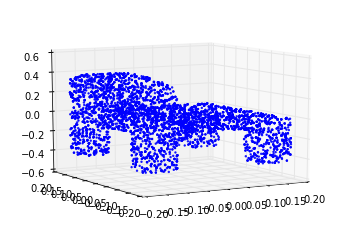

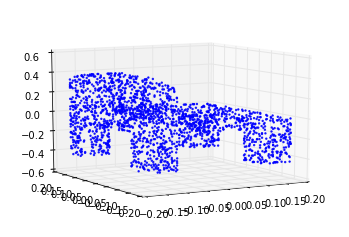

In [9]:
temp0 = np.array([p.split('.')[0] for p in part_model_names], dtype=object)
model_check = temp0[10]
pc_check = np.vstack(part_pclouds[np.where(model_check == temp0)])
Point_Cloud(pc_check).plot();

temp1 = np.array([f.split('.')[0] for f in full_model_ids], dtype=object)
Point_Cloud(full_pclouds[np.where(temp1 == model_check)[0]][0]).plot();

array(['b58909919d9feea6976cd10355a74f40.__1__.03001627',
       'cd939609247df917d9d3572bbd9cf789.__1__.03001627',
       'b1d9c55bd4e8ded1c76575d5e6d323f2.__3__.03001627', ...,
       'e6b0b43093f105277997a53584de8fa7.__1__.03001627',
       '2b69e899da0c15cfb40f0ac0fb9a650d.__2__.03001627',
       'bbadf45aa419015c7e4d369f13ed434e.__2__.03001627'], dtype=object)

### Link the partial to the complete data to make the training set for the linker


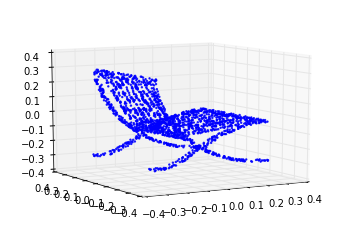

In [10]:
part_model_names
from tf_lab.autopredictors.scripts.helper import match_incomplete_to_complete_data
linking_ids = [i.split('.')[0] + '.' + class_restriction for i in part_model_names]

# # # linking_ids = [i.split('.')[0] + '.' + i.split('.')[2] for i in partial_model_ids]

mapping = match_incomplete_to_complete_data(full_model_ids, linking_ids)

mapping
check = 1
Point_Cloud(full_pclouds[mapping[check]]).plot();


# # # mixed_data = PointCloudDataSet(full_latent[mapping], labels=partial_model_ids, noise=partial_latent)
mixed_data = PointCloudDataSet(full_latent[mapping], labels=part_model_names, noise=part_latent)

In [11]:
reset_tf_graph()
init_lr = 0.0001
cgan = ConditionalGAN(learning_rate=init_lr, random_proj=False)

In [12]:
train_stats = []
batch_size = 50
for i in range(100):
    stat_i = cgan._single_epoch_train(mixed_data, batch_size, sigma=1)
    print stat_i
    train_stats.append(stat_i[0])

((0.59576627768484158, 5.0935173937322675), 3.6789448261260986)
((1.0690755912796459, 1.7658134242634715), 3.639533042907715)
((1.1217021370620885, 2.1774409386356179), 3.5834178924560547)
((1.2031194955233193, 2.3019082521705472), 3.5532491207122803)
((1.2968660774544924, 2.0718761318259769), 3.5837318897247314)
((1.2501081856189933, 1.5947022891829534), 3.5682148933410645)
((1.217734986862528, 1.5298417200767453), 3.564906120300293)
((1.2073348255314453, 1.5131631628476052), 3.5439701080322266)
((1.2696707908508709, 1.4474609962706704), 3.587651014328003)
((1.2557360498012338, 1.3340615051273457), 3.5970962047576904)
((1.2736323848673345, 1.3105052805241244), 3.643666982650757)
((1.2242583769829676, 1.3455885197400066), 3.5426061153411865)
((1.1414940138903173, 1.4214155178501773), 3.577367067337036)
((1.1050112686530063, 1.3864157962700958), 3.565605878829956)
((1.0465210985254358, 1.5652576496081096), 3.584836959838867)
((1.0393734763188618, 1.492897166391459), 3.592252016067505)
(

KeyboardInterrupt: 

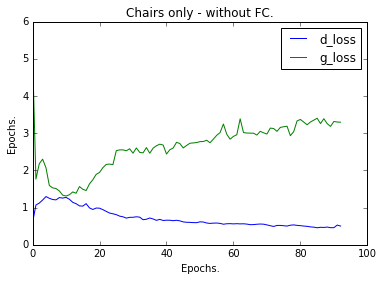

In [13]:
x = range(len(train_stats))
d_loss = [t[0] for t in train_stats]
g_loss = [t[1] for t in train_stats]
plt.plot(x, d_loss)
plt.plot(x, g_loss)
plt.legend(['d_loss', 'g_loss'], loc=0)
plt.xlabel('Epochs.')
plt.ylabel('Epochs.')
plt.title('Chairs only - without FC.')


In [42]:
def generate(self, part_latent, noise):
    feed_dict = {self.part_latent: part_latent, self.z: noise}
    return self.sess.run([self.generator_out], feed_dict=feed_dict)

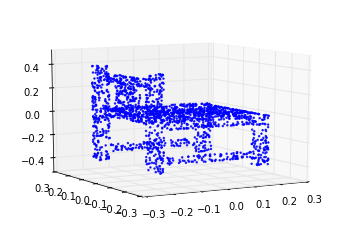

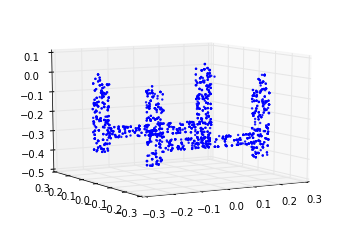

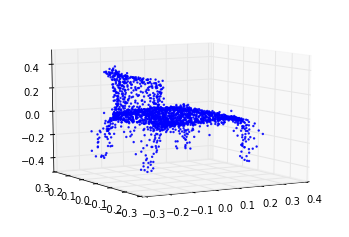

In [59]:
# complete_latent, part_name, part_latent = mixed_data.next_batch(1)
model_name, part_id, syn_id = part_name[0].split('.')

loc = np.where(full_model_ids == model_name + '.' + syn_id)[0]
Point_Cloud(full_pclouds[loc][0]).plot()
# Point_Cloud(full_ae.decode(complete_latent)[0]).plot();

loc = np.where(part_model_names == part_name)
Point_Cloud(part_pclouds[loc][0]).plot()
# Point_Cloud(part_ae.decode(part_latent)[0]).plot();

gan_complete_latent = generate(cgan, part_latent, cgan.generator_noise_distribution(1, 128, sigma=1))[0]
Point_Cloud(points=full_ae.decode(gan_complete_latent)[0]).plot();